<a href="https://colab.research.google.com/github/LeoMagallanes/Incident-Classifier/blob/main/Make_csv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
MagaLink = '/content/drive/MyDrive/IA/7mo sem/IntelligentsAgents/Proyecto/Incidents-subset'

CarlosLink ='/content/drive/MyDrive/Proyecto/Incidents-subset'

currentRoot = CarlosLink

In [ ]:
import os
import shutil
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, cohen_kappa_score, matthews_corrcoef, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
import ast
import random

from mpl_toolkits.mplot3d import Axes3D

from tensorflow import keras
from tensorflow.keras import layers

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model

# For the feature learning and building our custom dataset.
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import Dataset, DataLoader
from skimage import io
from skimage.feature import hog
from skimage.transform import resize

#Read Folder Data

In [ ]:
# Obtener la lista de nombres de las carpetas en el directorio principal
carpetas = [nombre for nombre in os.listdir(currentRoot) if os.path.isdir(os.path.join(currentRoot, nombre))]
name_categories = [nombre for nombre in os.listdir(currentRoot) if os.path.isdir(os.path.join(currentRoot, nombre))]

# Imprimir los nombres de las carpetas
for carpeta in carpetas:
    print(carpeta)

nuclear_explosion
ice_storm
flooded
bicycle_accident
collapsed
oil_spill
airplane_accident
tornado
car_accident
earthquake
volcanic_eruption
wildfire


In [ ]:
images = {}
folder_images_list=[]
# Iterate over each subfolder
count=0
for folder in os.listdir(currentRoot):
    folder_path = os.path.join(currentRoot, folder)
    if os.path.isdir(folder_path):
        # Get the names of the files in the subfolder
        files = os.listdir(folder_path)
        image_list=[]
        # Rename the files sequentially
        for i, file_name in enumerate(files, start=1):
            file_path = os.path.join(folder_path, file_name)
            new_file_name = f"{i}_{folder}{os.path.splitext(file_name)[1]}"
            new_file_path = os.path.join(folder_path, new_file_name)
            image_list.append(new_file_name)
            folder_images_list.append([folder,file_name,file_path])
            # Rename the file
            #try:
            #    os.rename(file_path, new_file_path)
            #except Exception:
            #    None
            #try:
            #    cv2.imread(new_file_path)
            #except cv2.error as e:
            #    count+=1
        images[folder]=image_list
print(count)

Amount of Images

In [ ]:
count = 0
for i in images:
#print(len(images[i]))
  count += 1
print(count)

7358


#Histograms

Extracter

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
from skimage.feature import local_binary_pattern
from skimage import exposure
# Function to calculate LBP histograms
def compute_lbp_histogram(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Calculate LBP features
    radius = 4
    n_points = 32 * radius
    lbp = local_binary_pattern(gray_image, n_points, radius, method='uniform')
    # Calculate the histogram of LBP features
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    # Normalize the histogram
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-7)
    return lbp_hist
image = cv2.imread('/content/drive/MyDrive/Proyecto/Incidents-subset/airplane_accident/120_airplane_accident.jpg')
image = cv2.resize(image, (1000,700))
print(np.array(compute_lbp_histogram(image)).shape)

(130,)


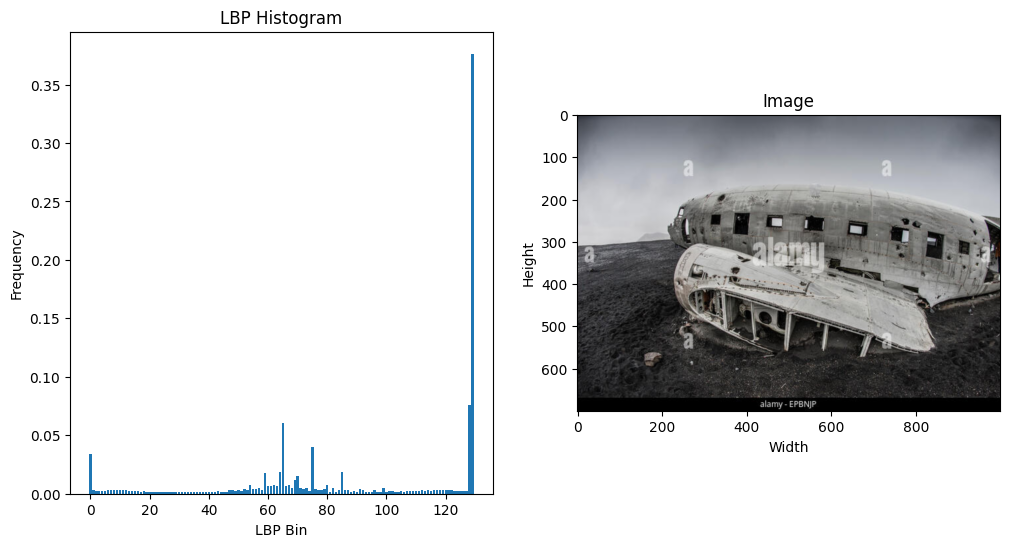

In [ ]:
import cv2
import matplotlib.pyplot as plt



# Load the image
image = cv2.imread('/content/drive/MyDrive/Proyecto/Incidents-subset/airplane_accident/122_airplane_accident.jpg')

# Resize the image
image = cv2.resize(image, (1000, 700))

# Compute the LBP histogram of the image
lbp_histogram = compute_lbp_histogram(image)

# Create a subplot grid with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the LBP histogram on the first subplot
ax1.bar(range(len(lbp_histogram)), lbp_histogram)
ax1.set_xlabel('LBP Bin')
ax1.set_ylabel('Frequency')
ax1.set_title('LBP Histogram')

# Plot the image on the second subplot
ax2.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax2.set_xlabel('Width')
ax2.set_ylabel('Height')
ax2.set_title('Image')

# Display the plots
plt.show()


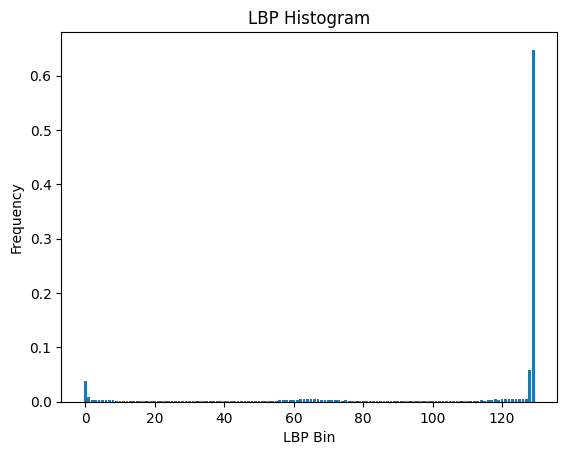

In [ ]:
import cv2
import matplotlib.pyplot as plt


# Load the image
image = cv2.imread('/content/drive/MyDrive/Proyecto/Incidents-subset/volcanic_eruption/102_volcanic_eruption.JPG')

# Resize the image
image = cv2.resize(image, (1000, 700))

# Compute the LBP histogram of the image
lbp_histogram = compute_lbp_histogram(image)

# Plot the LBP histogram
plt.bar(range(len(lbp_histogram)), lbp_histogram)
plt.xlabel('LBP Bin')
plt.ylabel('Frequency')
plt.title('LBP Histogram')
plt.show()

In [ ]:
directory = currentRoot

# Define the number of categories, channels, and bins
ncategories = 12
nchannels = 6
nbins = 256
histograms_list = [] # Initialize an empty list to store histograms
lbp_list=[]
countnnn=0

# Iterate over each subfolder
for i, folder in enumerate(os.listdir(directory)):
    folder_path = os.path.join(directory, folder)
    if os.path.isdir(folder_path):
        # Iterate over each image in the subfolder
        for image_name in os.listdir(folder_path):
            print(countnnn)
            countnnn+=1
            image_path = os.path.join(folder_path, image_name)
            if os.path.isfile(image_path):
                # Read the image
                image = cv2.imread(image_path)
                image = cv2.resize(image, (700,700))
                imgHSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                lbp_list.append([folder, image_name, compute_lbp_histogram(image)])
                # Calculate color histograms for each channel
                for c in range(nchannels):
                  if(c < 3):
                    channel_hist = cv2.calcHist([image], [c], None, [nbins], [0, 256])
                    # Append the histogram information to the list
                    histograms_list.append([folder, image_name, c, channel_hist.flatten()])
                  else:
                    channel_hist = cv2.calcHist([imgHSV], [c - 3], None, [nbins], [0, 256])
                    # Append the histogram information to the list
                    histograms_list.append([folder, image_name, c, channel_hist.flatten()])

# Create a DataFrame from the histograms list with appropriate column names
df = pd.DataFrame(histograms_list, columns=['Categorie', 'Image_name', 'Channel', 'Histogram'])

#Save to CSV to dont recompute
df.to_pickle(currentRoot+'\histograms.pkl')

Streaming output truncated to the last 5000 lines.
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433

Retrieve Saved Data

In [ ]:
# Read the CSV file
df = pd.read_pickle(currentRoot+'\histograms.pkl')

#Edges Feature Extraction

Edges Extractor Function

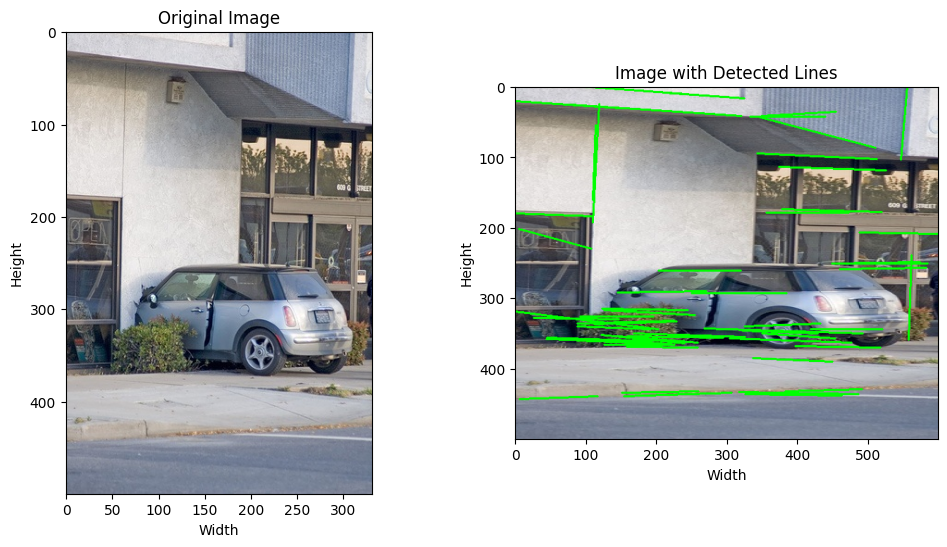

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the original image
image = cv2.imread('/content/drive/MyDrive/Proyecto/Incidents-subset/car_accident/360_car_accident.jpg')

# Resize the image for better visualization
new_width, new_height = 600, 500
resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

# Apply Canny edge detection to the resized image
edges = cv2.Canny(resized_image, 50, 150)

# Detect lines using Hough transform
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)

# Draw the detected lines on the resized image
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(resized_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Plot the original image and the image with the detected lines
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Original image
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_xlabel('Width')
ax1.set_ylabel('Height')
ax1.set_title('Original Image')

# Image with detected lines
ax2.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
ax2.set_xlabel('Width')
ax2.set_ylabel('Height')
ax2.set_title('Image with Detected Lines')

# Display the plots
plt.show()


In [ ]:
import cv2
import numpy as np
import os
from concurrent.futures import ThreadPoolExecutor

def process_image(image_list_data):
    image_path=image_list_data[2]
    image_name=image_list_data[1]
    folder=image_list_data[0]
    image = cv2.imread(image_path)

    # Resize the image to 600x500 with antialiasing
    new_width, new_height = 600, 500
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Apply Canny edge detection
    edges = cv2.Canny(image, 50, 150)

    # Detect lines using Hough transform
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)

    max_lines = 1000
    # Apply Canny edge detection
    edges = cv2.Canny(image, 50, 150)
    # Detect lines using Hough transform
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)
    # Extract line features and create feature vectors
    feature_vectors = []
    if lines is None:
      return [folder, image_name, [[0, 0]] * max_lines]  # Fill with max_lines lines of [0, 0]
    else:
      # Sort the lines by length in descending order
      sorted_lines = sorted(lines, key=lambda line: np.sqrt((line[0][2] - line[0][0]) ** 2 + (line[0][3] - line[0][1]) ** 2), reverse=True)
      # Iterate over the sorted lines and add them to the feature vectors
      for i, line in enumerate(sorted_lines):
        if i >= max_lines:
          break  # Limit the number of lines to max_lines
        x1, y1, x2, y2 = line[0]
        length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        angle = np.arctan2((y2 - y1), (x2 - x1))
        feature_vector = [length, angle]
        feature_vectors.append(feature_vector)

      # Fill with 0 if there are not enough lines
      while len(feature_vectors) < max_lines:
        feature_vectors.append([0, 0])
      return [folder, image_name, feature_vectors]

Edge Extracter Starter

In [ ]:
lines_list = []
for i,image_list_data in enumerate(folder_images_list):
  image_path=image_list_data[2]
  image_name=image_list_data[1]
  folder=image_list_data[0]
  lines_list.append([folder, image_name, process_image(image_list_data)[2]])
  print(f"Processed: {image_name} : {i}")
print("All images processed.")
# Create a DataFrame from the histograms list with appropriate column names
dfLines = pd.DataFrame(lines_list, columns=['Categorie', 'Image_name', 'Lines'])

# Save the cloned DataFrame to a pkl file
dfLines.to_pickle(currentRoot+'\lines.pkl')

Retrieve Saved Information

In [ ]:
dfLines = pd.read_pickle(currentRoot+'\lines.pkl')

,Categorie,Image_name,Lines
0,nuclear_explosion,144_nuclear_explosion.JPG,"[[690.9913168774265, -0.05357188003058359], [6..."
1,nuclear_explosion,92_nuclear_explosion.jpg,"[[254.0, 0.0], [251.0, 0.0], [237.0, 0.0], [20..."
2,nuclear_explosion,88_nuclear_explosion.jpg,"[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0..."
3,nuclear_explosion,78_nuclear_explosion.jpg,"[[172.5340546095176, -0.7853981633974483], [16..."
4,nuclear_explosion,118_nuclear_explosion.jpg,"[[145.08618128546908, 0.034469100999508014], [..."
...,...,...,...
7353,wildfire,416_wildfire.jpg,"[[263.82570003697515, 0.3481233352806847], [22..."
7354,wildfire,194_wildfire.jpg,"[[307.77426793024785, -0.10742795360465592], [..."
7355,wildfire,196_wildfire.jpg,"[[420.0214280248092, -0.7853981633974483], [40..."
7356,wildfire,252_wildfire.jpg,"[[272.8094573140748, -1.098952180044178], [271..."


#Moments

Image Moment Extracter

In [ ]:
# Directory containing the subfolders
directory = currentRoot

# Define the number of categories, channels, and bins
ncategories = 12

# Initialize an empty list to store histograms
moments_list = []
cn=0
# Iterate over each subfolder
for i, folder in enumerate(os.listdir(directory)):
    folder_path = os.path.join(directory, folder)
    if os.path.isdir(folder_path):
        # Iterate over each image in the subfolder
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            if os.path.isfile(image_path):
                image = cv2.imread(image_path)
                print(image_path,cn)
                cn+=1
                # Convertir la imagen al espacio de color HSV
                gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

                # Calcular los momentos de color en el espacio de color HSV
                moments = cv2.moments(gray_image)

                # Extraer los momentos de color
                hue_moment = moments['m00']  # Momento de matiz (H)
                saturation_moment = moments['m01']  # Momento de saturación (S)
                value_moment = moments['m02']  # Momento de valor (V)

                moments_list.append([folder, image_name, hue_moment, saturation_moment,value_moment])


# Create a DataFrame from the histograms list with appropriate column names
dfMoments = pd.DataFrame(moments_list, columns=['Categorie', 'Image_name', 'HM', 'SM','VM'])

# Save the cloned DataFrame to a pkl file
dfMoments.to_pickle(currentRoot+'\moments.pkl')

Retrieve Saved Data

In [ ]:
dfMoments=pd.read_pickle(currentRoot+'\moments.pkl')

#CNN Feature Extraction

In [ ]:
dfDescriptors = pd.read_pickle(currentRoot + '/descriptors.pickle')

In [ ]:
descriptors=dfDescriptors.values[:][2]

In [ ]:
descriptors[2]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
del dfDescriptors

In [ ]:
from sklearn.decomposition import PCA

# Assuming descriptors is your array of features with shape (num_samples, num_features)
num_components = 1000  # Set the desired number of components (lower than the original num_features)
pca = PCA(n_components=num_components)
reduced_descriptors = pca.fit_transform(descriptors)


ValueError: ignored

In [ ]:
import torch
import timm

# Load the pretrained Vision Transformer model (ViT) with a specific variant, e.g., 'vit_base_patch16_224'
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Print the model architecture to see the details
print(model)

ModuleNotFoundError: ignored

In [ ]:
# Load the pretrained VGG-16 model
model = torchvision.models.vgg16(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch
import torchvision
import cv2
from torchvision import transforms

# Step 1: Load the pre-trained VGG-16 model
model = torchvision.models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch
import os
import cv2
import numpy as np
from torchvision import transforms
import pandas as pd

import torchvision

# Load the pretrained VGG-19 model with batch normalization
model = torchvision.models.vgg19_bn(pretrained=True)

# Initialize arrays to store features, labels, and file names
descriptors = []
y_labels = []
names = []

count = 0

for folder in os.listdir(currentRoot):
    folder_path = os.path.join(currentRoot, folder)
    if os.path.isdir(folder_path):
        files = os.listdir(folder_path)

        for i, file_name in enumerate(files, start=1):
            # Get the images of the files in the subfolder

            print(count)
            count += 1

            # Extract features using the pre-trained VGG-19 model

            file_path = os.path.join(folder_path, file_name)
            # Step 2: Load and preprocess the input image
            image_path = file_path
            image = cv2.imread(image_path)

            preprocess = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

            input_image = preprocess(image)
            input_batch = torch.unsqueeze(input_image, 0)

            # Step 3: Perform the forward pass to get the model's prediction for the input image
            model.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                output = model(input_batch)

            # Step 4: Apply the softmax function to obtain the probability distribution
            softmax = torch.nn.Softmax(dim=1)
            probability_distribution = softmax(output)

            # Step 5: Extract the probabilities vector from the probability distribution
            probabilities_vector = np.array(probability_distribution[0])

            # Extract features from the image batch
            descriptors.append(probabilities_vector)
            y_labels.append(folder)
            names.append(file_name)

# Create a DataFrame from descriptors and y_labels
data = {'Categorie': y_labels, 'Image_name': names, 'descriptors': descriptors}
dfDescriptors = pd.DataFrame(data)

# Specify the file path to save the pickle file
pickle_file = currentRoot + '/descriptorsVgg19.pickle'

# Save the DataFrame to pickle
dfDescriptors.to_pickle(pickle_file)

print("Data saved to", pickle_file)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:07<00:00, 80.8MB/s]


Se truncaron las últimas líneas 5000 del resultado de transmisión.
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
254

Load Pretrained Model

In [ ]:
dfDescriptors

,Categorie,Image_name,descriptors
0,nuclear_explosion,144_nuclear_explosion.JPG,"[7.97938e-08, 4.3612894e-05, 1.9814818e-06, 1...."
1,nuclear_explosion,92_nuclear_explosion.jpg,"[1.7263424e-06, 0.0003311039, 0.0020486098, 0...."
2,nuclear_explosion,88_nuclear_explosion.jpg,"[1.6742217e-06, 9.122061e-05, 0.0002151936, 0...."
3,nuclear_explosion,78_nuclear_explosion.jpg,"[9.5287895e-08, 2.5070158e-05, 0.00013521376, ..."
4,nuclear_explosion,118_nuclear_explosion.jpg,"[3.2453722e-06, 3.1319792e-05, 4.679872e-05, 2..."
...,...,...,...
7353,wildfire,416_wildfire.jpg,"[3.3129977e-06, 8.411192e-05, 0.00018238414, 0..."
7354,wildfire,194_wildfire.jpg,"[1.3019769e-06, 3.9605675e-07, 2.1889735e-05, ..."
7355,wildfire,196_wildfire.jpg,"[0.00010097254, 0.00012427004, 7.097466e-05, 0..."
7356,wildfire,252_wildfire.jpg,"[1.0041985e-05, 0.00012716645, 8.427478e-05, 0..."


In [ ]:
model = torchvision.models.resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 110MB/s]


Descriptors Extractor

In [ ]:
#Ocupo un array que tenga de elementos tuplas. para guardar width and height.
descriptors = []
y_labels = []
names = []
count = 0
for folder in os.listdir(currentRoot):
    folder_path = os.path.join(currentRoot, folder)
    if os.path.isdir(folder_path):
        files = os.listdir(folder_path)

        for i, file_name in enumerate(files, start=1):
          # Get the images of the files in the subfolder

          print(count)
          count += 1

          # Extract features using the pre-trained ResNet-18 model

          file_path = os.path.join(folder_path, file_name)
          image = cv2.imread(file_path)

          preprocess = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
          ])

          input_image = preprocess(image)
          input_batch = torch.unsqueeze(input_image, 0)

          # Extract features from the image batch
          descriptors.append(model(input_batch).flatten().detach().numpy())
          y_labels.append(folder)
          names.append(file_name)

In [ ]:
len(descriptors)

7358

Save the Descriptos

In [ ]:
import pickle

# Create a DataFrame from descriptors and y_labels
data = {'Categorie': y_labels, 'Image_name': names, 'descriptors': descriptors}
dfDescriptors = pd.DataFrame(data)

# Specify the file path to save the pickle file
pickle_file = currentRoot + '/descriptors.pickle'

# Save the DataFrame to pickle
dfDescriptors.to_pickle(pickle_file)

print("Data saved to", pickle_file)

Data saved to /content/drive/MyDrive/Proyecto/Incidents-subset/descriptors.pickle


Retrieve Previous Descriptors

In [ ]:
#Read pickle
pickle_file = currentRoot + '/descriptors.pickle'

dfDescriptors = pd.read_pickle(pickle_file)
print(dfDescriptors)

              Categorie                 Image_name  \
0     nuclear_explosion  144_nuclear_explosion.JPG   
1     nuclear_explosion   92_nuclear_explosion.jpg   
2     nuclear_explosion   88_nuclear_explosion.jpg   
3     nuclear_explosion   78_nuclear_explosion.jpg   
4     nuclear_explosion  118_nuclear_explosion.jpg   
...                 ...                        ...   
7353           wildfire           416_wildfire.jpg   
7354           wildfire           194_wildfire.jpg   
7355           wildfire           196_wildfire.jpg   
7356           wildfire           252_wildfire.jpg   
7357           wildfire           559_wildfire.jpg   

                                            descriptors  
0     [2.941442e-08, 3.6996164e-06, 5.5356654e-06, 8...  
1     [9.004555e-07, 0.0003685161, 0.00035883483, 0....  
2     [2.0680775e-06, 8.171643e-05, 5.2016432e-05, 8...  
3     [4.3481286e-08, 2.6684781e-06, 1.7297272e-05, ...  
4     [2.4385906e-06, 6.1028462e-05, 7.621606e-05, 2...  
...

In [ ]:
import pickle

# Create a DataFrame from descriptors and y_labels
data = {'Categorie': y_labels, 'Image_name': names, 'descriptors': descriptors}
dfDescriptors = pd.DataFrame(data)

# Specify the file path to save the pickle file
pickle_file = currentRoot + '/descriptors.pickle'

# Save the DataFrame to pickle
dfDescriptors.to_pickle(pickle_file)

print("Data saved to", pickle_file)

Data saved to /content/drive/MyDrive/IA/7mo sem/IntelligentsAgents/Proyecto/Incidents-subset/descriptors.pickle


In [ ]:
model = torchvision.models.resnet152(pretrained=True)
image_path = '/content/drive/MyDrive/Proyecto/Incidents-subset/airplane_accident/100_airplane_accident.jpg'
image = cv2.imread(image_path)

preprocess = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

input_image = preprocess(image)
input_batch = torch.unsqueeze(input_image, 0)

# Step 3: Perform the forward pass to get the model's prediction for the input image
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
  output = model(input_batch)

# Step 4: Apply the softmax function to obtain the probability distribution
softmax = torch.nn.Softmax(dim=1)
probability_distribution = softmax(output)

# Step 5: Extract the probabilities vector from the probability distribution
probabilities_vector = np.array(probability_distribution[0])

np.sum(probabilities_vector)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 143MB/s]


0.99999994

#HOG Histograms

Example just one image

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog
from skimage.transform import resize

orientations = 8
pixels_per_cell = (64, 64)
cells_per_block = (1, 1)
image = cv2.imread('/content/drive/MyDrive/Proyecto/Incidents-subset/airplane_accident/100_airplane_accident.jpg') # Read the image

image = cv2.resize(image, (600, 500))
# Calculate the HOG features
features = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, multichannel=True)
features = np.array(features)

<ipython-input-12-12bf003243b0>:15: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, multichannel=True)


Trying to see an image after extracting hog

<ipython-input-30-6b5a724fd38d>:21: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features, hog_image = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=True, multichannel=True)


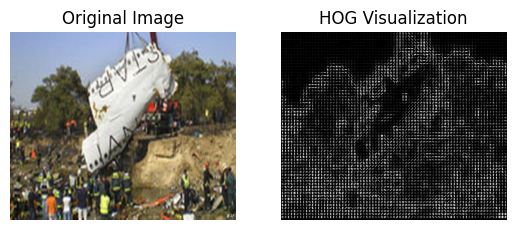

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.transform import resize
from skimage import exposure

orientations = 8
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)

# Read the image
image = cv2.imread('/content/drive/MyDrive/IA/7mo sem/IntelligentsAgents/Proyecto/Incidents-subset/airplane_accident/106_airplane_accident.jpg')

# Resize the image for visualization (optional)
image = cv2.resize(image, (600, 500))

# Calculate the HOG features
features, hog_image = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=True, multichannel=True)

# Rescale the HOG image for better visualization
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Plot the HOG visualization
plt.subplot(1, 2, 2)
plt.imshow(hog_image_rescaled, cmap='gray')
plt.title('HOG Visualization')
plt.axis('off')

plt.show()


All the images HOG feature vector extraction

In [ ]:
directory = currentRoot

# Define the number of orientations, pixels per cell, and cells per block
orientations = 8
pixels_per_cell = (64, 64)
cells_per_block = (1, 1)

hog_histograms_list = [] # Initialize an empty list to store HOG histograms

countnnn=0

# Iterate over each subfolder
for i, folder in enumerate(os.listdir(directory)):
    folder_path = os.path.join(directory, folder)
    if os.path.isdir(folder_path):
        # Iterate over each image in the subfolder
        for image_name in os.listdir(folder_path):
            print(countnnn)
            countnnn+=1
            image_path = os.path.join(folder_path, image_name)
            if os.path.isfile(image_path):
                image = cv2.imread(image_path) # Read the image

                image = cv2.resize(image, (600, 500))
                # Calculate the HOG features
                features = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, multichannel=True)
                features = np.array(features)
                # Append the HOG features to the list
                hog_histograms_list.append([folder, image_name, features])

# Create a DataFrame from the HOG histograms list with appropriate column names
df_hog = pd.DataFrame(hog_histograms_list, columns=['Categorie', 'Image_name', 'HOG'])

# Save the DataFrame to a pickle file
df_hog.to_pickle(currentRoot+'/hog_histograms.pkl')

Retrieve the saved Data

In [ ]:
dfHOG = pd.read_pickle(currentRoot +'/hog_histograms.pkl')

# Combinations

In [ ]:
from itertools import combinations

# Define all categories
all_categories = carpetas  # Add all 12 categories

# Define the number of categories to consider in each combination
categories_per_combination = 4

# Get all combinations of categories
category_combinations = list(combinations(all_categories, categories_per_combination))

# Initialize a dictionary to store the accuracies for each combination
accuracies = {}

# Create a DataFrame from X and y
df = pd.DataFrame({'Feature_vector': X, 'Categorie': y})

nn=0
# Iterate through each combination
for combination in category_combinations:
    nn+=1
    print((nn/495))
    # Filter the DataFrame to keep only the desired categories
    df_filtered = df[df['Categorie'].isin(combination)].copy()

    # Split the filtered data into training and testing sets
    X_filtered = df_filtered['Feature_vector'].tolist()
    y_filtered = df_filtered['Categorie'].tolist()

    X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=87, stratify=y_filtered)
    # Normalize the columns of the feature vectors in both the training and test sets
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    # Initialize and train the Random Forest Classifier
    clf = RandomForestClassifier(n_estimators=50, random_state=20020902)
    clf.fit(X_train, y_train)

    # Predict the labels for the test set
    y_pred = clf.predict(X_test)

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store the accuracy for the current combination
    accuracies[combination] = [accuracy,balanced_accuracy,f1]

# Print the accuracies for each combination
for combination, accuracy in accuracies.items():
    print(f"Combination: {combination}, Metrics: {accuracy}")

# Convert the accuracies dictionary to a list
accuracies_list = [(combination,) + tuple(metrics) for combination, metrics in accuracies.items()]

# Create the DataFrame with the desired columns
combinations4_df = pd.DataFrame(accuracies_list, columns=['Combination', 'Accuracy', 'Balanced Accuracy', 'F1 Score'])

# Save the DataFrame to a pickle file
combinations4_df.to_pickle(currentRoot + '\combinations4.pkl')

Random classifier

In [ ]:
df = pd.read_pickle(currentRoot+'\histograms.pkl')
dfLines = pd.read_pickle(currentRoot+'\lines.pkl')
dfMoments=pd.read_pickle(currentRoot+'\moments.pkl')
dfDescriptors = pd.read_pickle(currentRoot + '/descriptors.pickle')
dfHOG = pd.read_pickle(currentRoot +'/hog_histograms.pkl')
dfLBP = pd.read_pickle(currentRoot+'\LBP.pkl')

In [ ]:
feature_df = df.groupby(['Categorie', 'Image_name']).apply(lambda x: np.concatenate(x['Histogram'].values)).reset_index()
feature_df.columns = ['Categorie', 'Image_name', 'Feature_vector']

# Merge merged_df with dfMoments based on 'Categorie' and 'Image_name'
merged_df = pd.merge(feature_df, dfLines, on=['Categorie', 'Image_name'], how='inner')
merged_df = pd.merge(merged_df, dfMoments, on=['Categorie', 'Image_name'], how='inner')
merged_df = pd.merge(merged_df, dfDescriptors, on=['Categorie', 'Image_name'], how='inner')
merged_df = pd.merge(merged_df, dfLBP, on=['Categorie', 'Image_name'], how='inner')
merged_df = pd.merge(merged_df, dfHOG, on=['Categorie', 'Image_name'], how='inner') # Merge merged_df with dfHOG based on 'Categorie' and 'Image_name'

del feature_df
# Append the values from 'MeanLines' and 'StdLines' columns to the 'Feature_vector' column
merged_df['Feature_vector'] = merged_df.apply(lambda row: np.concatenate((
    row['Feature_vector'],row['LBP'],row['HOG'],np.concatenate(row['Lines'][:500]),row['descriptors'])), axis=1)
#merged_df['Feature_vector'] = merged_df.apply(lambda row: np.concatenate( row['HOG']), axis=1)

# Replace NaN values with 0 in the 'Feature_vector' colum

print(merged_df.shape)
# Split the merged DataFrame into features (X) and target labels (y)
#X = merged_df['Feature_vector'].tolist()
X = merged_df['Feature_vector'].apply(lambda x: x[:]).tolist()
y = merged_df['Categorie'].tolist()

del merged_df
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=87, stratify=y)

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Normalize the columns of the feature vectors in both the training and test sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
#merged_df['Feature_vector'] = merged_df.apply(lambda row: np.concatenate( row['HOG']), axis=1)
#X_train=X_train[:,:3000]
#X_test=X_train[:,:3000


(7358, 10)


In [ ]:
X = pd.DataFrame(X)
Y = pd.Series(y)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
def train_model(model, X, Y):
    # Initialize lists to store evaluation metrics and confusion matrices for each fold
    metrics_list = []

    # Create 5-fold stratified cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Iterate over each fold
    for fold, (train_index, test_index) in enumerate(skf.split(X, Y), 1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        model.fit(X_train, Y_train) # Fit the model to the training data

        Y_pred = model.predict(X_test) # Predict the labels on the test data

        # Calculate evaluation metrics
        accuracy = accuracy_score(Y_test, Y_pred)
        balanced_accuracy = balanced_accuracy_score(Y_test, Y_pred)
        f1 = f1_score(Y_test, Y_pred, average='weighted')
        auc_roc = roc_auc_score(Y_test, model.predict_proba(X_test), average='weighted', multi_class='ovo')
        precision = precision_score(Y_test, Y_pred, average='weighted')
        recall = recall_score(Y_test, Y_pred, average='weighted')
        kappa = cohen_kappa_score(Y_test, Y_pred)
        mcc = matthews_corrcoef(Y_test, Y_pred)

        # Append the metrics to the list
        metrics_list.append([fold, accuracy, balanced_accuracy, f1, auc_roc, precision, recall, kappa, mcc])

    # Create a DataFrame from the metrics list
    metrics_df = pd.DataFrame(metrics_list, columns=['Fold', 'Accuracy', 'Balanced Accuracy', 'F1 Score', 'AUC/ROC', 'Precision', 'Recall', 'Kappa', 'MCC'])

    # Calculate the mean and standard deviation of the metrics
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    # Append the mean and std dev to the metrics DataFrame
    metrics_df = metrics_df.append(mean_metrics, ignore_index=True)
    metrics_df = metrics_df.append(std_metrics, ignore_index=True)
    metrics_df.iloc[-2, 0] = "Mean"
    metrics_df.iloc[-1, 0] = "Std Dev"

    return metrics_df

In [ ]:
def random_classifier(X_test, n_classes):
    np.random.seed(42)  # Set a seed for reproducibility
    Y_pred = np.random.choice(n_classes, size=len(X_test))

    return Y_pred

In [ ]:
metrics_df_random

,Fold,Accuracy,Balanced Accuracy,F1 Score,Precision,Recall,Kappa,MCC
0,1.0,0.084239,0.082328,0.089288,0.100887,0.084239,-0.001004,-0.001012
1,2.0,0.084239,0.082458,0.089266,0.100839,0.084239,-0.000987,-0.000995
2,3.0,0.084918,0.083077,0.089939,0.101479,0.084918,-0.000240,-0.000242
3,4.0,0.084976,0.083124,0.090019,0.101651,0.084976,-0.000135,-0.000136
4,5.0,0.084976,0.083073,0.090032,0.101678,0.084976,-0.000155,-0.000156
5,Mean,0.084670,0.082812,0.089709,0.101307,0.084670,-0.000504,-0.000508
6,Std Dev,0.000394,0.000386,0.000396,0.000413,0.000394,0.000450,0.000454


Testing how the model perform for the different sections of the feature vector

In [ ]:
# Load the datasets for each feature set
df_histograms = pd.read_pickle(currentRoot + '\histograms.pkl')
df_lines = pd.read_pickle(currentRoot + '\lines.pkl')
df_moments = pd.read_pickle(currentRoot + '\moments.pkl')
df_descriptors = pd.read_pickle(currentRoot + '/descriptors.pickle')
df_hog = pd.read_pickle(currentRoot + '/hog_histograms.pkl')
df_lbp = pd.read_pickle(currentRoot + '\LBP.pkl')



In [ ]:
# Create the Random Forest Classifier with 500 trees
random_forest = RandomForestClassifier(n_estimators=500, random_state=42)

# Train the model with different feature sets
metrics_df_histograms = train_model(random_forest, df_histograms, Y)
metrics_df_lines = train_model(random_forest, df_lines, Y)
metrics_df_moments = train_model(random_forest, df_moments, Y)
metrics_df_descriptors = train_model(random_forest, df_descriptors, Y)
metrics_df_hog = train_model(random_forest, df_hog, Y)
metrics_df_lbp = train_model(random_forest, df_lbp, Y)

In [ ]:
df_lines.shape

(7358, 3)

In [ ]:
X = df_histograms['Histogram'].apply(lambda x: x[:]).tolist()
print(X)

KeyboardInterrupt: ignored